In [1]:
import os 
cwd = os.getcwd()
import sys
sys.path.append("C:/Users/gomel/Documents/global_python_codes/Metrics_thresholds_boots") # go to parent dir

sys.path.append("C:/Users/gomel/Documents/Programing Proyects/EE indicators/Simulations with pdfs to test/Stochastic equations/SDE tests jupyter") # go to parent dir
import sde_analysis as sa

import sympy as sp
import ewstools as ews
import numpy as np
import sdeint
import metrics
import boots as bts
import scipy.stats as st
import astropy.stats as astrost
import scipy.signal as sg
from scipy import special

import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 18})
plt.rcParams.update({
    "text.usetex": False,
    "font.family": "serif"    
})
import matplotlib.lines as lines
CB_color_cycle = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']

from sympy import lambdify

c1=(221/256,170/256,51/256)
c2=(187/256,85/256,102/256)
c3=(0,68/256,136/256)
cols=(c1,c2,c3)

This is a simulation of a onlinear equation with aditive noise using a Heun method where the noise only applies on the variable and not the parameter. 

\begin{equation}
\dot{x}=-(x-10 erf(\lambda))
\end{equation}

where $x$ is a random variable and $\lambda$ is a swiped parameter determined by $\dot{\lambda }=c_\lambda $. Here $c_\lambda $ should be small enough for the parameter to be moving 'adiabatically' with respect to the dynamics of the system. 


This system has one fixed point that moves to a different value .

$f'=-1$

$f''=0$

the stochastic equation is 

\begin{equation}
\dot{x}=-(x-10 erf(\lambda))+\sigma dW
\end{equation}

where W is a (0,1) white noise process and $\sigma$ the intensity of the noise. Here $\dot{x}=-(x-10 erf(\lambda))$ is called the deterministic skeleton of the stochastic equation.



In [2]:
xs, ls = sp.symbols('xs lambda')
eq=(-(xs-10*sp.erf(ls)))
M=-1
sp.solve(eq, xs)


[10*erf(lambda)]

In [3]:

sol1=10*sp.erf(ls)
sp_dxdl=sp.diff(sol1,ls)



cl= sp.symbols('c')
rl= sp.symbols('r')

Mr=-1
adiab=sp.solve(ls/0.02+1/(2*Mr), ls)
adiab=sp.N(adiab[0]) 
ad1 = lambdify([ls],ls/0.1+1/(2*Mr))


ad0 = lambdify([ls],ls/0.1-1/(2*1))
radiab=sp.solve(0.1/(Mr)-1, ls)
Mr

-1

In [4]:
def m_sol1(mvar):
    mv=mvar
    return special.erf(10*mv)


### Characteristic time-scale exploration

First we do a deterministic integration to estimate the time-scale of the transition.

In [5]:
l0=2
lf=-2
cls=0.05
cl=np.sign(lf-l0)*cls
s=0.01


adiab=sp.solve(ls/cl-1/(2*Mr), ls)
adiab=sp.N(adiab[0]) 
ad1 = lambdify([ls],ls/cl-1/(2*Mr))

adiab2=sp.solve(ls/cl-1/(Mr), ls)
adiab2=sp.N(adiab2[0]) 
ad2 = lambdify([ls],ls/cl-1/(Mr))
adiab3=sp.solve(ls/cls+10/(Mr), ls)
adiab3=sp.N(adiab3[0]) 
M1 = lambdify([ls],Mr)


t_final=(lf-l0)/cl
t_rm=np.abs(1/1)
t_threshold=t_rm/2
dt=t_threshold/4
t_win=t_rm/dt ### length of correlation. 
    
datalen=t_final/(600*7*10)
if datalen>=t_threshold/2: 
    datalen=t_threshold/2
    
tspan=np.arange(0,t_final,datalen)
print(r'$\Delta t= $', tspan[1]-tspan[0], 't_final:', t_final)
print('correlation time: ', t_win)
print('data length: ', len(tspan))
print('dot lambda: ', cl)

x0= np.array([special.erf(l0*10)]) 
 #       x0= np.array([0.]) 

def f(x, t):
    #X=x[0]. dot(x)=r(x-2)*(x-1)*(x-3)
    #r=x[1]. dot(r)=cte.  This is a constant swipe of parameter r at speed dot(r). 
#    A=np.array([x[1]*x[0]+x[0]**3-x[0]**5,-2*r0/t_final*special.erf(x[1]) ])
    l=l0+cl*t
    A=np.array([-(x[0]-special.erf(l*10))])
    return A

def G(x, t):
    #B=[ 'noise in x'         0    ]
    #  [      0        'noise in r']
    B = np.diag([s]) # diagonal, so independent driving Wiener processes
    #the only parameter with relevant aditive noise is X(t) in this case. 
    return B
np.random.seed(1) #set numpy.random seed for reproducibility whenever it might be used.
l_var=np.linspace(lf,l0,20)
l=l0+cl*tspan
dl=cl*tspan[1]-l0


result = sdeint.stratHeun(f, G, x0, tspan)
print('Integration DOOONNEE')


$\Delta t= $ 0.0019047619047619048 t_final: 80.0
correlation time:  8.0
data length:  42000
dot lambda:  -0.05
Integration DOOONNEE


In [6]:
adiab

0.0250000000000000

In [7]:
adiab2

0.0500000000000000

In [8]:
adiab3

0.500000000000000

In [9]:
t_rm/dt

8.0

$dt$:  0.0019047619047619048


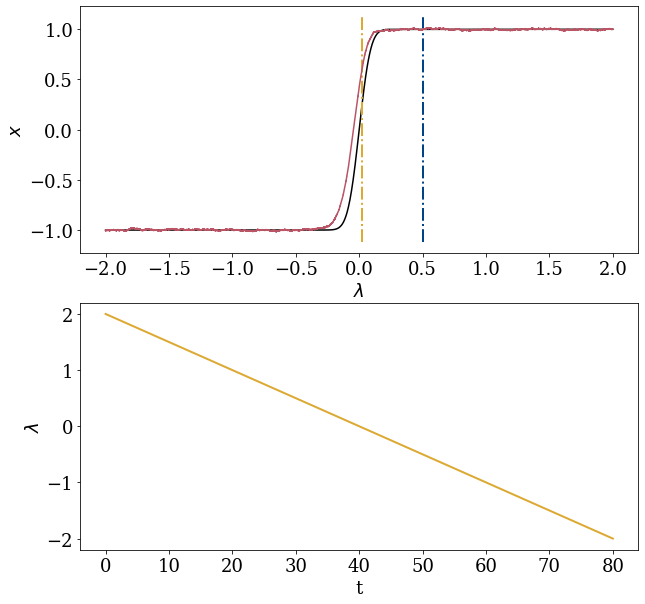

In [10]:
fig=plt.figure(figsize=(10,10))
ax=fig.add_subplot(211)
plt.plot(l,result[:,0],color=c2,zorder=10)
plt.plot(l,m_sol1(l),'-',color='black')
ylim=ax.get_ylim()
ax.plot([adiab3,adiab3],ylim,'-.',linewidth=2,color=c3,alpha=1,label='tracking')
ax.plot([adiab,adiab],ylim,'-.',linewidth=2,color=c1,alpha=1,label='tracking')

#lt.plot(result[result[:,1]>0,1],result[result[:,1]>0,0],'r')
plt.xlabel(r'$\lambda$')
plt.ylabel('$x$')
plt.subplot(212)
plt.plot(tspan,l,color=c1,lw=2)
plt.xlabel('t')
plt.ylabel(r'$\lambda$')
#print('$\dot{r}$: ',dot_r,(result[2,1]-result[1,1])/(tspan[2]-tspan[1]) )
print('$dt$: ',tspan[2]-tspan[1])



#### Integration scheme: 

Here I use the sdeint python package to integrate based on the Heun scheme. This decision is based on the paper "Integration of stochastic differential equations on a computer" from R.Manella.
DOI: 10.1142/S0129183102004042


Here i do a set of 'n' runs to do statististics on: 

## Detrended

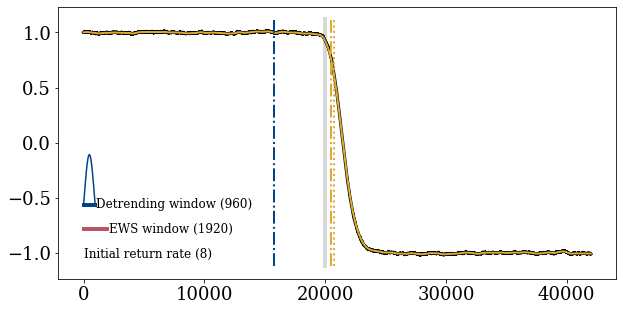

In [11]:
from scipy import signal

bootstrapping=False
smoothing=True

bif_idx=np.abs(0.1-l).argmin()

trans=bif_idx
res=result[:,0]
dlen=len(res)
t=np.arange(0,len(res),1)
ind_f=t
adiab_idx=np.abs(adiab-l).argmin()
adiab2_idx=np.abs(adiab2-l).argmin()
adiab3_idx=np.abs(adiab3-l).argmin()

varwin=np.int64(15*t_win/dt)
ewswin=np.int64(30*t_win/dt)
ts = ews.TimeSeries(data=res)  ### ews stats ### 

bw=varwin/2.2
if smoothing==True:
    ts.detrend(method='Gaussian',bandwidth=bw, span=varwin)
    smooth=ts.state['smoothing'].values
    residuals=ts.state['residuals'].values
    data=residuals

    fig=plt.figure(figsize=(10,5))
    ax=fig.add_subplot(111)
    plt.plot(t,res,'-',color='black',lw=3)
    plt.plot(t,smooth,color=c1,lw=2)
    
ylim=ax.get_ylim()  
yvwin=ylim[0]+(ylim[1]-ylim[0])*0.25    
ywin=ylim[0]+(ylim[1]-ylim[0])*0.15   
ytcor=ylim[0]+(ylim[1]-ylim[0])*0.05   
plt.plot([0,ewswin],[ywin,ywin],color=c2,lw=4,label='EWS window')
plt.plot([0,varwin],[yvwin,yvwin],color=c3,lw=4,label='Detrending window')
gwin=signal.windows.gaussian(varwin, std=bw)
plt.plot([0,t_rm/dt],[ytcor,ytcor],color=c3,lw=4,label='Initial correlation')
plt.plot(gwin-np.min(gwin)+yvwin,color=c3)

ax.annotate('EWS window (%.1i)'%(ewswin),
            xy=(ewswin*1.1, ywin), xycoords='data',
            horizontalalignment='left', verticalalignment='center',
            fontsize=12)
ax.annotate('Detrending window (%.1i)'%(varwin),
            xy=(varwin*1.1, yvwin), xycoords='data',
            horizontalalignment='left', verticalalignment='center',
            fontsize=12)
ax.annotate('Initial return rate (%.1i)'%(t_rm/dt),
            xy=(t_rm/dt*1.2, ytcor), xycoords='data',
            horizontalalignment='left', verticalalignment='center',
            fontsize=12)
ax.plot([trans,trans],ylim,'-',linewidth=4,color='gray',alpha=0.3,label='Bifurcation')


ax.plot([adiab_idx,adiab_idx],ylim,':',linewidth=2,color=c1,alpha=1,label='Bifurcation')
ax.plot([adiab2_idx,adiab2_idx],ylim,'-.',linewidth=2,color=c1,alpha=1,label='Bifurcation')
ax.plot([adiab3_idx,adiab3_idx],ylim,'-.',linewidth=2,color=c3,alpha=1,label='tracking')



In [12]:
t_adiab=-1/np.real(M1(complex(adiab2)))
t_adiab/dt

8.0

In [13]:
from importlib import reload
reload(sa)

<module 'sde_analysis' from 'C:\\Users/gomel/Documents/Programing Proyects/EE indicators/Simulations with pdfs to test/Stochastic equations/SDE tests jupyter\\sde_analysis.py'>

In [14]:
tidx,ac_labels,ac1,ac2,var_ews,sk_ews,ku_ews,rtw,hogg2,moors,RTWc= sa.make_stats(tspan,t,ts,varwin,ewswin)


if bootstrapping==True:
    dlen=len(ac1)
    mean_b=np.zeros([dlen,2])
    var_b=np.zeros([dlen,2])
    skew_b=np.zeros([dlen,2])
    kur_b=np.zeros([dlen,2])
    kr2_b=np.zeros([dlen,2])
    kr3_b=np.zeros([dlen,2])
    RTW_b=np.zeros([dlen,2])
    ac1_std=np.zeros([dlen,2])

   

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


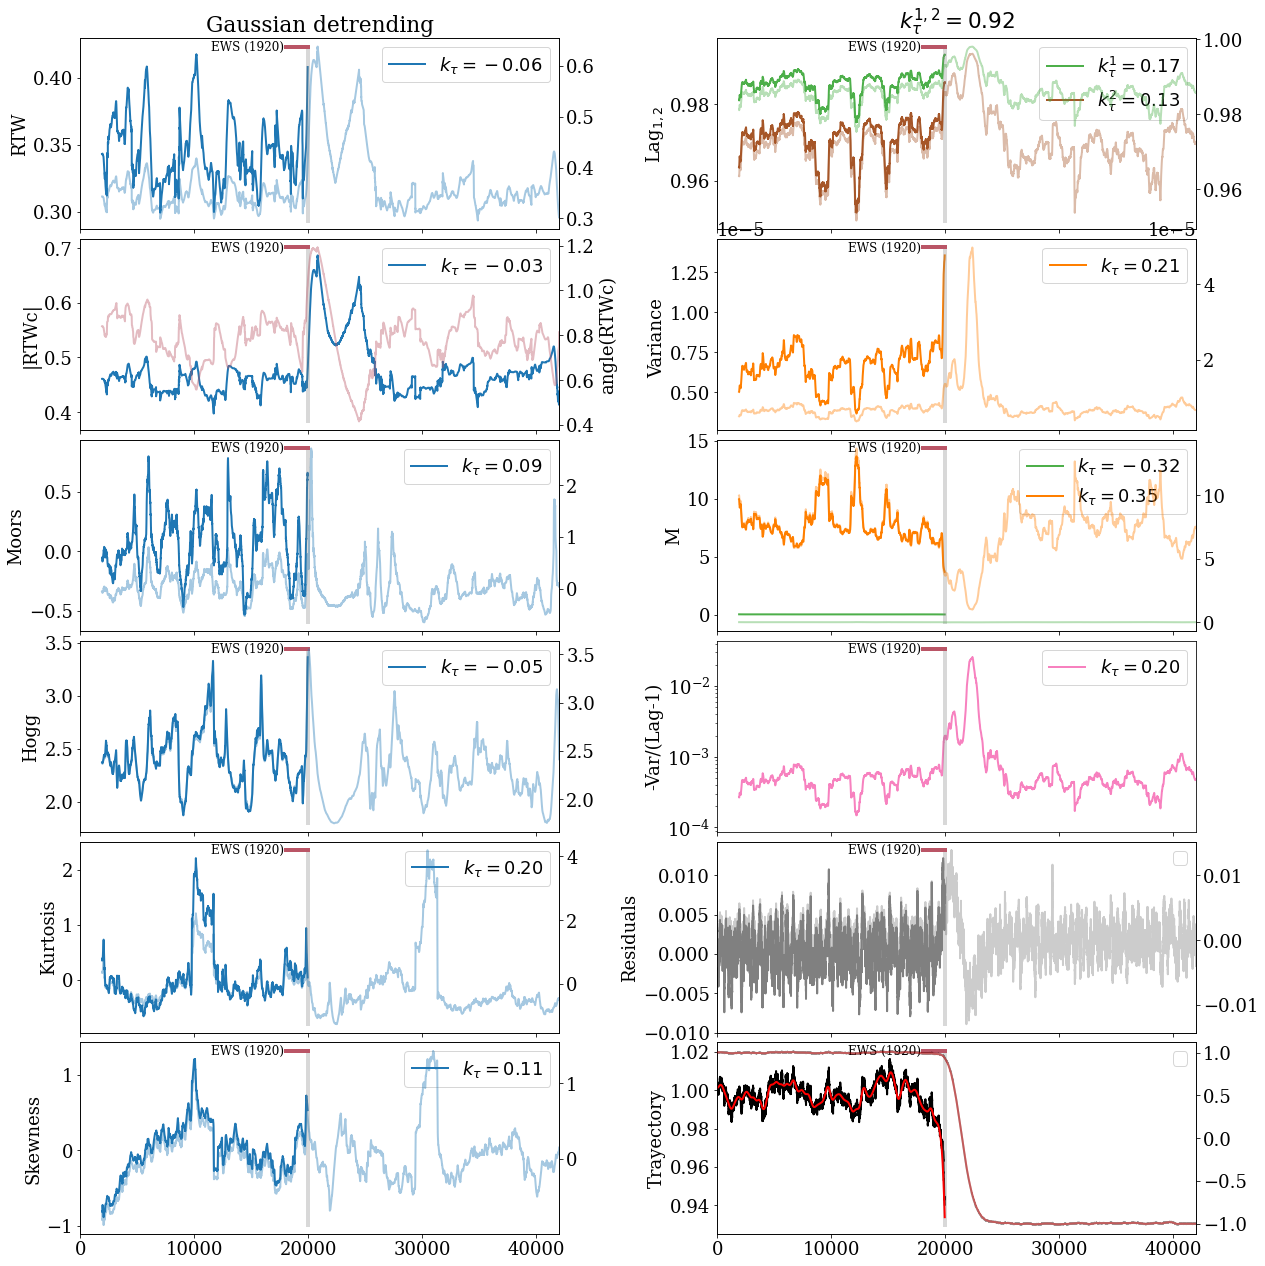

In [15]:
fig=sa.stats_plot(bif_idx,tidx,ind_f,s,rtw,RTWc,moors,hogg2,ac1,ku_ews,sk_ews,ac2,var_ews,residuals,res,smooth,smoothing,ewswin)
fig.savefig('./Gdet_additive.png'  , dpi = 130, bbox_inches='tight')# when saving, specify the DPI


C:\Users\gomel\AppData\Local\Temp\ipykernel_36104\1577366487.py:9: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  plt.xlim([0,len(res)])


Text(0.5, 1.0, 'Angle RTWc ')

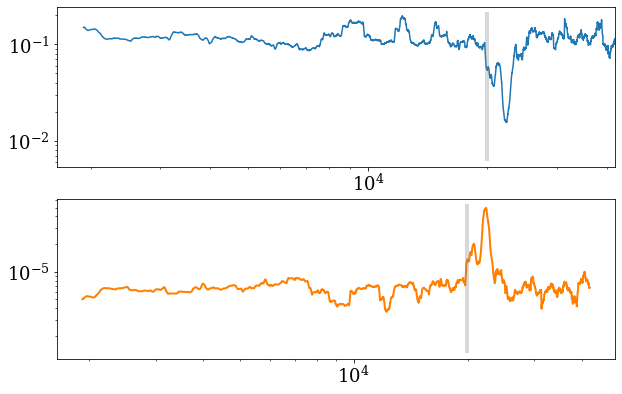

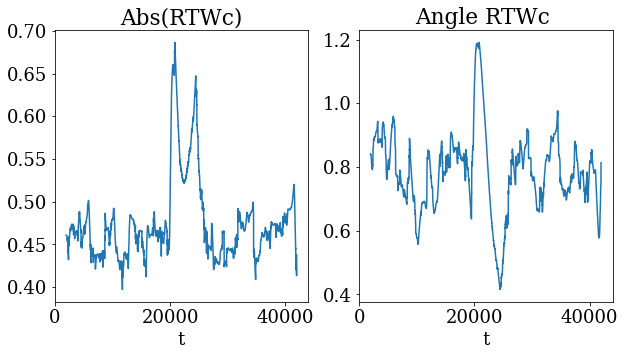

In [16]:
fig=plt.figure(figsize=(10,10))
ax=fig.add_subplot(311)
plt.plot(-(ac1-1)/dt)
ylim=ax.get_ylim()
plt.plot([trans,trans],ylim,'-',linewidth=4,color='gray',alpha=0.3)
plt.yscale('log')
plt.xscale('log')

plt.xlim([0,len(res)])
ax=fig.add_subplot(312)
plt.plot(ind_f,var_ews,color=CB_color_cycle[1],linewidth=2,label=r'$k_{\tau}=%.2f$' %(ts.ktau['variance']))
ylim=ax.get_ylim()
plt.plot([trans,trans],ylim,'-',linewidth=4,color='gray',alpha=0.3)

plt.yscale('log')
plt.xscale('log')


plt.figure(figsize=(10,5))
plt.subplot(121)
plt.plot(tidx,np.abs(RTWc))
#plt.plot(tspan[result[:,1]>0],skew[result[:,1]>0],'r')
plt.xlabel('t')
plt.title('Abs(RTWc)')

plt.subplot(122)
plt.plot(tidx,np.unwrap(np.angle(RTWc)))
#plt.plot(tspan[result[:,1]>0],skew[result[:,1]>0],'r')
plt.xlabel('t')
plt.title('Angle RTWc ')

## Non detrended data:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


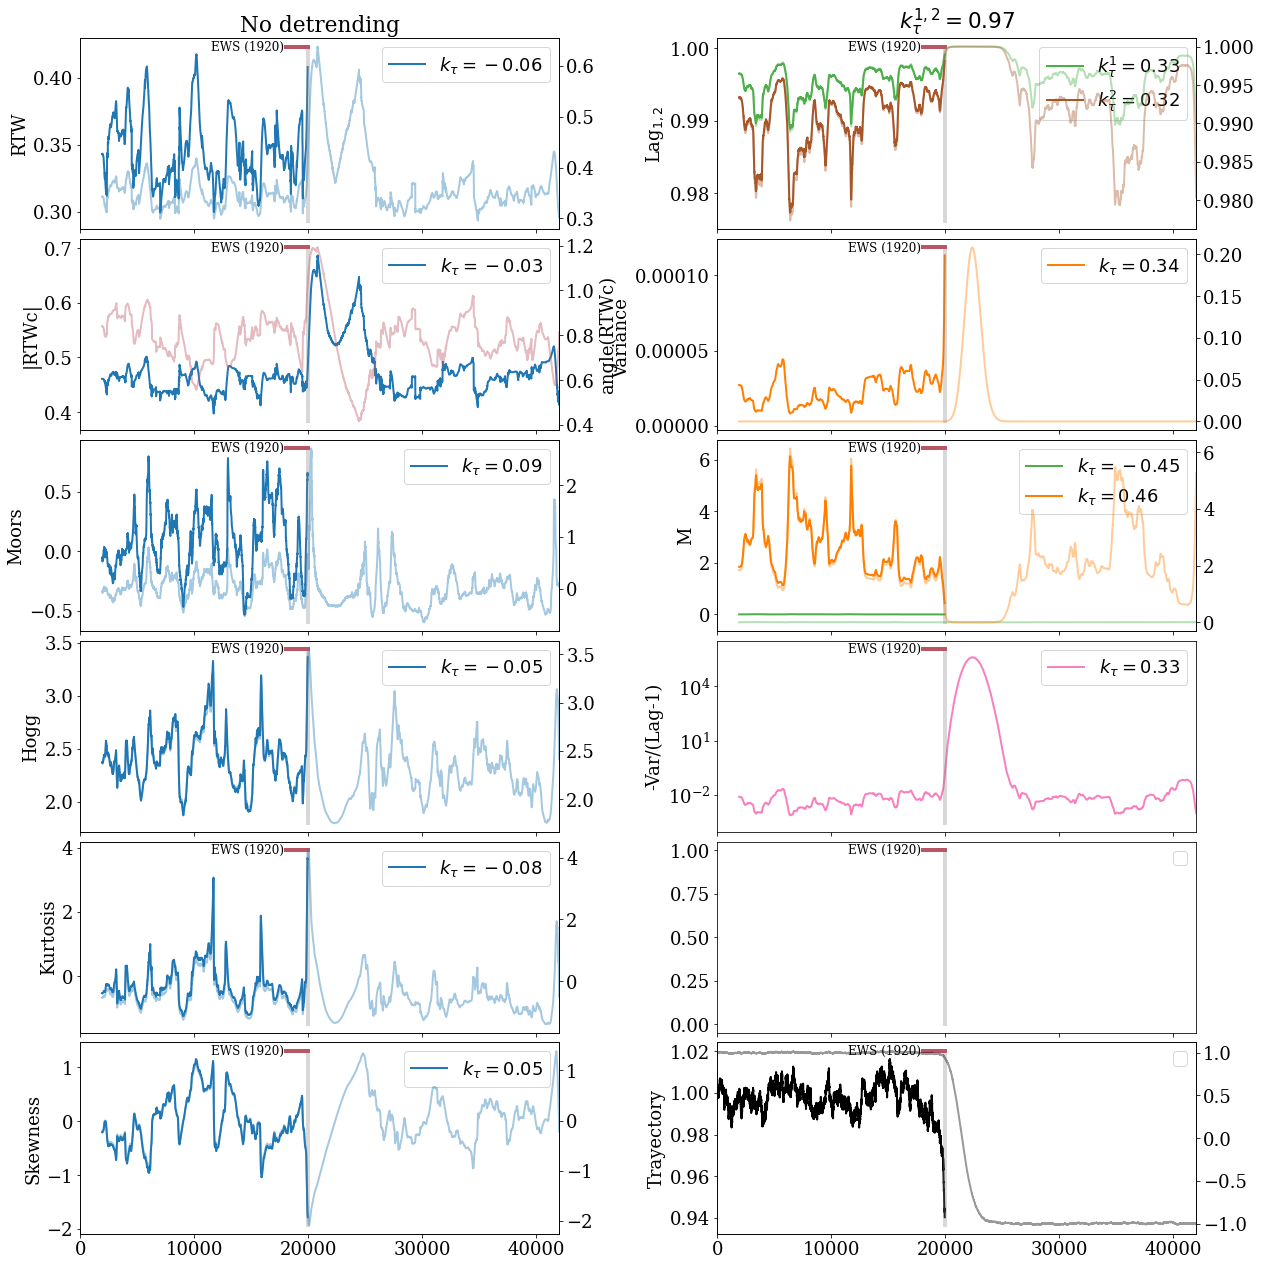

In [17]:

bootstrapping=False
smoothing=False

ts = ews.TimeSeries(data=res)  ### ews stats ### 
tidx,ac_labels,ac1,ac2,var_ews,sk_ews,ku_ews,rtw,hogg2,moors,RTWc= sa.make_stats(tspan,t,ts,varwin,ewswin)

if bootstrapping==True:
    dlen=len(ac1)
    mean_b=np.zeros([dlen,2])
    var_b=np.zeros([dlen,2])
    skew_b=np.zeros([dlen,2])
    kur_b=np.zeros([dlen,2])
    kr2_b=np.zeros([dlen,2])
    kr3_b=np.zeros([dlen,2])
    RTW_b=np.zeros([dlen,2])
    ac1_std=np.zeros([dlen,2])

fig=sa.stats_plot(bif_idx,tidx,ind_f,s,rtw,RTWc,moors,hogg2,ac1,ku_ews,sk_ews,ac2,var_ews,residuals,res,smooth,smoothing,ewswin)
fig.savefig('./No_det_additive.png'  , dpi = 130, bbox_inches='tight')# when saving, specify the DPI

C:\Users\gomel\AppData\Local\Temp\ipykernel_36104\999709303.py:9: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  plt.xlim([0,len(res)])


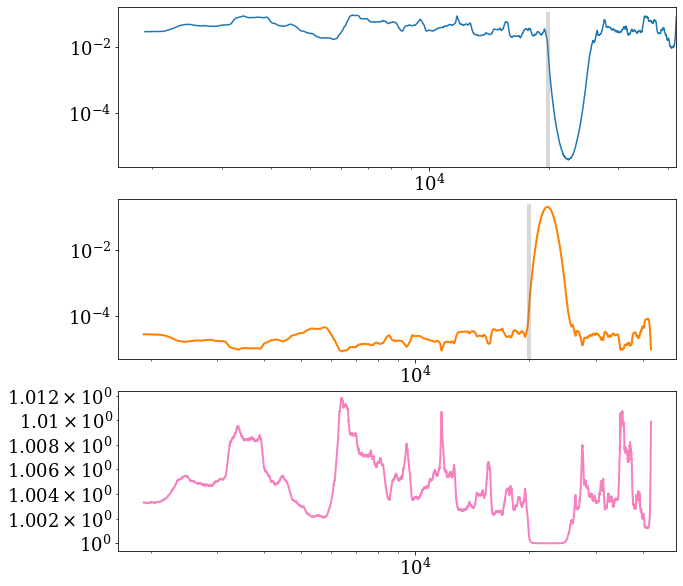

In [18]:
fig=plt.figure(figsize=(10,10))
ax=fig.add_subplot(311)
plt.plot(-(ac1-1)/dt)
ylim=ax.get_ylim()
plt.plot([trans,trans],ylim,'-',linewidth=4,color='gray',alpha=0.3)
plt.yscale('log')
plt.xscale('log')

plt.xlim([0,len(res)])
ax=fig.add_subplot(312)
plt.plot(ind_f,var_ews,color=CB_color_cycle[1],linewidth=2,label=r'$k_{\tau}=%.2f$' %(ts.ktau['variance']))
ylim=ax.get_ylim()
plt.plot([trans,trans],ylim,'-',linewidth=4,color='gray',alpha=0.3)

plt.yscale('log')
plt.xscale('log')

ax=fig.add_subplot(313)
plt.plot(ind_f,ac1/ac2,color=CB_color_cycle[3],linewidth=2,label=r'$k_{\tau}=%.2f$' %(ts.ktau['variance']))
plt.yscale('log')
plt.xscale('log')


To do: 

- implement WOTAN package detrending
- fix bootstraping

 vr_b = bts.boot_result(bts.blockbootstrap(np.var,res,n_resample_case,rep=True,sd=1,perc=sample_perc)[0])
    var[j]= vr_b[0]
    var_b[j]=vr_b[1][0],vr_b[1][1]
    sk_b = bts.boot_result(bts.blockbootstrap(st.skew,res,n_resample_case,rep=True,sd=1,perc=sample_perc)[0])
    skew[j]= sk_b[0]
    skew_b[j]=sk_b[1][0],sk_b[1][1]
    sk_b = bts.boot_result(bts.blockbootstrap(np.mean,res,n_resample_case,rep=True,sd=1,perc=sample_perc)[0])
    mean[j]= sk_b[0]
    mean_b[j]=sk_b[1][0],sk_b[1][1]
    sk_b = bts.boot_result(bts.blockbootstrap(st.kurtosis,res,n_resample_case,rep=True,sd=1,perc=sample_perc)[0])
    kur[j]= sk_b[0]
    kur_b[j]=sk_b[1][0],sk_b[1][1]
    sk_b = bts.boot_result(bts.blockbootstrap(metrics.RTW_max,res,n_resample_case,rep=True,sd=1,perc=sample_perc)[0])
    RTW[j]= sk_b[0]
    RTW_b[j]=sk_b[1][0],sk_b[1][1]
    try:
        sk_b = bts.boot_result(bts.blockbootstrap(metrics.kr2,res,n_resample_case,rep=True,sd=1,perc=sample_perc)[0])
        kr2[j]= sk_b[0]
        kr2_b[j]= sk_b[1][0],sk_b[1][1]
        sk_b = bts.boot_result(bts.blockbootstrap(metrics.kr3,res,n_resample_case,rep=True,sd=1,perc=sample_perc)[0])
        kr3[j]= sk_b[0]
        kr3_b[j]= sk_b[1][0],sk_b[1][1]
    except:
        continue

Integration DOOONNEE
$dt$:  0.0019047619047619048


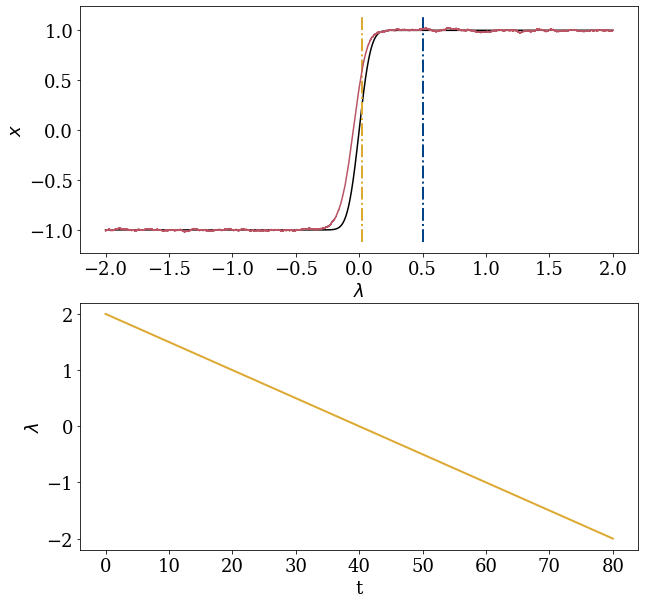

In [19]:
def G(x, t):
    #B=[ 'noise in x'         0    ]
    #  [      0        'noise in r']
    B = np.diag([s*x[0]]) # diagonal, so independent driving Wiener processes
    #the only parameter with relevant aditive noise is X(t) in this case. 
    return B
np.random.seed(1) #set numpy.random seed for reproducibility whenever it might be used.
l_var=np.linspace(lf,l0,20)
l=l0+cl*tspan
dl=cl*tspan[1]-l0


result2 = sdeint.stratHeun(f, G, x0, tspan)
print('Integration DOOONNEE')

fig=plt.figure(figsize=(10,10))
ax=fig.add_subplot(211)
plt.plot(l,result2[:,0],color=c2,zorder=10)
plt.plot(l,m_sol1(l),'-',color='black')
ylim=ax.get_ylim()
ax.plot([adiab3,adiab3],ylim,'-.',linewidth=2,color=c3,alpha=1,label='tracking')
ax.plot([adiab,adiab],ylim,'-.',linewidth=2,color=c1,alpha=1,label='tracking')
#lt.plot(result[result[:,1]>0,1],result[result[:,1]>0,0],'r')
plt.xlabel(r'$\lambda$')
plt.ylabel('$x$')
plt.subplot(212)
plt.plot(tspan,l,color=c1,lw=2)
plt.xlabel('t')
plt.ylabel(r'$\lambda$')
#print('$\dot{r}$: ',dot_r,(result[2,1]-result[1,1])/(tspan[2]-tspan[1]) )
print('$dt$: ',tspan[2]-tspan[1])


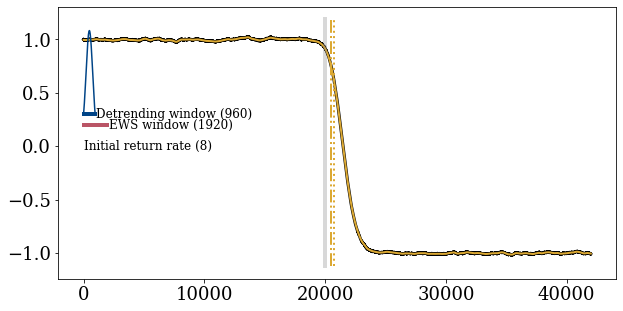

In [20]:
from scipy import signal

bootstrapping=False
smoothing=True


trans=bif_idx
res=result2[:,0]
dlen=len(res)
t=np.arange(0,len(res),1)
ind_f=t
adiab_idx=np.abs(adiab-l).argmin()
adiab2_idx=np.abs(adiab2-l).argmin()

ts = ews.TimeSeries(data=res)  ### ews stats ### 

bw=varwin/3.5
if smoothing==True:
    ts.detrend(method='Gaussian',bandwidth=bw, span=varwin)
    smooth=ts.state['smoothing'].values
    residuals=ts.state['residuals'].values
    data=residuals

    fig=plt.figure(figsize=(10,5))
    ax=fig.add_subplot(111)
    plt.plot(t,res,'-',color='black',lw=3)
    plt.plot(t,smooth,color=c1,lw=2)
    
plt.plot([0,ewswin],[0.2,0.2],color=c2,lw=4,label='EWS window')
plt.plot([0,varwin],[0.3,0.3],color=c3,lw=4,label='Detrending window')
gwin=signal.windows.gaussian(varwin, std=bw)
plt.plot([0,t_rm/dt],[0,0],color=c3,lw=4,label='Initial correlation')

plt.plot(gwin-np.min(gwin)+0.3,color=c3)
#line = Line2D(x, y)
#plt.legend()
ax.annotate('EWS window (%.1i)'%(ewswin),
            xy=(ewswin*1.1, 0.2), xycoords='data',
            horizontalalignment='left', verticalalignment='center',
            fontsize=12)
ax.annotate('Detrending window (%.1i)'%(varwin),
            xy=(varwin*1.1, 0.3), xycoords='data',
            horizontalalignment='left', verticalalignment='center',
            fontsize=12)
ax.annotate('Initial return rate (%.1i)'%(t_rm/dt),
            xy=(t_rm/dt*1.2, 0.0), xycoords='data',
            horizontalalignment='left', verticalalignment='center',
            fontsize=12)
ylim=ax.get_ylim()
ax.plot([trans,trans],ylim,'-',linewidth=4,color='gray',alpha=0.3,label='Bifurcation')


ax.plot([adiab_idx,adiab_idx],ylim,':',linewidth=2,color=c1,alpha=1,label='Bifurcation')
ax.plot([adiab2_idx,adiab2_idx],ylim,'-.',linewidth=2,color=c1,alpha=1,label='Bifurcation')


In [21]:
tidx,ac_labels,ac1,ac2,var_ews,sk_ews,ku_ews,rtw,hogg2,moors,RTWc= sa.make_stats(tspan,t,ts,varwin,ewswin)

if bootstrapping==True:
    dlen=len(ac1)
    mean_b=np.zeros([dlen,2])
    var_b=np.zeros([dlen,2])
    skew_b=np.zeros([dlen,2])
    kur_b=np.zeros([dlen,2])
    kr2_b=np.zeros([dlen,2])
    kr3_b=np.zeros([dlen,2])
    RTW_b=np.zeros([dlen,2])
    ac1_std=np.zeros([dlen,2])


In [22]:
fig=sa.stats_plot(bif_idx,tidx,ind_f,s,rtw,moors,kr2,ac1,ku_ews,sk_ews,ac2,var_ews,residuals,res,smooth,smoothing,ewswin)

NameError: name 'kr2' is not defined

## not detrended data

In [ ]:

bootstrapping=False
smoothing=False

ts = ews.TimeSeries(data=res)  ### ews stats ### 
data=res

if smoothing==True:
    ts.detrend(method='Gaussian',bandwidth=0.01, span=varwin)
    smooth=ts.state['smoothing'].values
    residuals=ts.state['residuals'].values
    data=residuals
    fig=plt.figure(figsize=(10,5))
    plt.plot(t,res)
    plt.plot(t,smooth)
    
    
tidx,ac_labels,ac1,ac2,var_ews,sk_ews,ku_ews,rtw,kr2,kr3,moors,RTWc=sa.make_stats(tspan,t,ts,varwin,ewswin)
fig=sa.stats_plot(bif_idx,tidx,ind_f,s,rtw,moors,kr2,ac1,ku_ews,sk_ews,ac2,var_ews,residuals,res,smooth,smoothing,ewswin)

In [ ]:
#cambiar kr2 por moors, pasar s como argument, o s*x